In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import _linear
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle

from plot_module import text_plot
from plot_module import structure_vocabulary_plots
from plot_module import ComparePlots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL

In [2]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'w')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'r')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)    

number of not one byte characters:  0
min order index:  9
max order index:  255
total number of characters:  196


In [3]:
#different
offset = 20000
valid_size = 10000
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99350000 n in the February 1934 riots, anarchists divided over a 'united 
10000 ture in Mutual Aid: A Factor of Evolution (1897). Subsequent ana


In [4]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)


string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print("Vocabulary: ", string_vocabulary)
print("char2id(u'a') = %s,  char2id(u'z') = %s,  char2id(u' ') = %s" % (char2id(u'a', characters_positions_in_vocabulary),
                                                                        char2id(u'z', characters_positions_in_vocabulary),
                                                                        char2id(u' ', characters_positions_in_vocabulary)))
print("id2char(78) = %s,  id2char(156) = %s,  id2char(140) = %s" % (id2char(78,
                                                                            vocabulary),
                                                                    id2char(156,
                                                                            vocabulary),
                                                                    id2char(140,
                                                                            vocabulary)))


Vocabulary:  	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ
char2id(u'a') = 67,  char2id(u'z') = 92,  char2id(u' ') = 2
id2char(78) = l,  id2char(156) = Ø,  id2char(140) = È


In [5]:
batch_size_test=64
num_unrollings_test=10

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)

print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))

[u'n in the Fe', u".\n* ''[[Con", u"oldier's so", u'\xf6hm-Bawerk ', u'tification,', u' warrior, a', u'uot; would ', u' 115       ', u'orbata acid', u'>\n      <co', u'ate, the co', u'other natio', u'ing the his', u'et bromine;', u' Christ&quo', u' average]] ', u' their home', u'ks and a ri', u'on]]/[[Joel', u' new era fo', u'aph that th', u' known as t', u's from the ', u'ast majorit', u'trips, thou', u'ent of regi', u'metric aspe', u'd named by ', u'Z</timestam', u'tude of 1 c', u'!&quot; [ht', u'o ==\n\n* [[D', u'[[Belarusia', u'iton]], Rus', u'ccessful si', u'es his theo', u' explain th', u' the South.', u'sing with a', u'd ball is h', u'e could des', u'[Friedrich ', u'th virtuall', u' foreign ac', u'variant in ', u'd and watch', u"t; ''[[Foot", u' became Lea', u'stern Europ', u' </contribu', u'ese terms n', u'arting in t', u'gence of th', u'of the cons', u'uickly swit', u', thus star', u'lly develop', u'g the offic', u'esult, the ', u'red HMMWV. ', u'ament is de', u'University ', 

In [11]:
indices_GL = {"batch_size": 0,
              "num_unrollings": 1,
              "num_layers": 2,
              "num_nodes": 3,
              "half_life": 4,
              "decay": 5,
              "num_steps": 6,
              "averaging_number": 7,
              "type": 8}


class RNN(MODEL):
    def layer(self, 
              inp_t,
              state_t_minus_1,
              layer_num):
        X_t = tf.concat(1, [inp_t,
                            state_t_minus_1])
        RES = tf.matmul(X_t, self.Matrices[layer_num]) + self.Biases[layer_num]
        state_t = tf.tanh(RES)
        return state_t

    
    def iteration(self, inp, state):
        num_layers = len(state)
        new_state = list()
        inter_state = self.layer(inp,
                                 state[0],
                                 0)
        new_state.append(inter_state)
        if num_layers > 1:
            for i in range(num_layers-1):
                inter_state = self.layer(inter_state,
                                         state[i+1],
                                         i+1)
                new_state.append(inter_state)
        return inter_state, new_state
    
    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_layers,
                 num_nodes,
                 train_text,
                 valid_text,
                 mean=0.,
                 stddev='default',
                 shift=0.,
                 init_learning_rate=0.5):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        self._num_unrollings = num_unrollings
        self._num_layers = num_layers
        self._num_nodes = num_nodes
        self._train_text = train_text
        self._valid_text = valid_text
        self._valid_size = len(valid_text)
        
        self._mean = mean
        
        self._stddev = list()
        if stddev == 'default':
            self._stddev.append(1.0 * np.sqrt(1./(num_nodes[0] + vocabulary_size)))
            for i in range(num_layers-1):
                self._stddev.append(1.0 * np.sqrt(1./(num_nodes[i+1] + num_nodes[i])))
        else:
            self._stddev = [stddev for _ in range(num_layers)]
            
        self._shift = shift
        self._init_learning_rate = init_learning_rate
        
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "half_life": 4,
                         "decay": 5,
                         "num_steps": 6,
                         "averaging_number": 7,
                         "init_mean": 8,
                         "init_stddev": 9,
                         "init_shift": 10,
                         "init_learning_rate": 11,
                         "type": 12}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            with self._graph.device('/gpu:0'): 
                self.Matrices = list()
                self.Biases = list()
                self.Matrices.append(tf.Variable(tf.truncated_normal([self._vocabulary_size + self._num_nodes[0],
                                                                      self._num_nodes[0]],
                                                                     mean=self._mean, stddev=self._stddev[0])))
                self.Biases.append(tf.Variable([self._shift for _ in range(self._num_nodes[0])]))
                if self._num_layers > 1:
                    for i in range(self._num_layers - 1):
                        self.Matrices.append(tf.Variable(tf.truncated_normal([self._num_nodes[i] + self._num_nodes[i+1],
                                                                              self._num_nodes[i+1]],
                                                                             mean=self._mean, stddev=self._stddev[i+1])))
                        self.Biases.append(tf.Variable([self._shift for _ in range(self._num_nodes[i+1])]))


                # classifier 
                weights = tf.Variable(tf.truncated_normal([self._num_nodes[-1], self._vocabulary_size],
                                                          mean=self._mean,
                                                          stddev=0.1))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.

                saved_state = list()
                for i in range(self._num_layers):
                    saved_state.append(tf.Variable(tf.zeros([self._batch_size, self._num_nodes[i]]), trainable=False))

                outputs = list()
                first_inputs = list()
                first_outputs = list()
                state = saved_state
                for i in train_inputs:
                    output, state = self.iteration(i, state)
                    outputs.append(output)
                    first_inputs.append(tf.split(0, self._batch_size, i)[0])
                    first_outputs.append(tf.split(0, self._batch_size, output)[0])

                self.first_inputs = tf.concat(0, first_inputs)
                self.first_outputs = tf.nn.softmax(tf.nn.xw_plus_b(tf.concat(0, first_outputs), weights, bias))
                save_list = list()
                for i in range(self._num_layers):
                    save_list.append(saved_state[i].assign(state[i]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)

                with tf.control_dependencies(save_list):
                        # Classifier.
                    logits = tf.nn.xw_plus_b(tf.concat(0, outputs), weights, bias)
                    """loss"""
                    self._loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                        logits, tf.concat(0, train_labels)))
                # Optimizer.
                self._global_step = tf.Variable(0)
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(self._init_learning_rate,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)
                gradients, v = zip(*optimizer.compute_gradients(self._loss))
                gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
                """optimizer"""
                self._optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)
                """train prediction"""
                self._train_prediction = tf.nn.softmax(logits)

                # Sampling and validation eval: batch 1, no unrolling.
                saved_sample_state = list()
                for i in range(self._num_layers):
                    saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[i]]), trainable=False)) 
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])

                reset_list = list()
                for i in range(self._num_layers):
                    reset_list.append(saved_sample_state[i].assign(tf.zeros([1, self._num_nodes[i]])))

                """reset sample state"""
                self._reset_sample_state = tf.group(*reset_list)

                sample_output, sample_state = self.iteration(self._sample_input, saved_sample_state)

                sample_save_list = list()
                for i in range(self._num_layers):
                    sample_save_list.append(saved_sample_state[i].assign(sample_state[i]))

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, weights, bias)) 
                
                
                """saver"""
                self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)
        metadata.append(self._num_layers)
        metadata.append(self._num_nodes)
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append(self._mean)
        metadata.append(self._stddev)
        metadata.append(self._shift)
        metadata.append(self._init_learning_rate)
        metadata.append('rnn')
        return metadata
  

In [12]:
model = RNN(64,
            vocabulary,
            characters_positions_in_vocabulary,
            10,
            1,
            [96],
            train_text,
            valid_text,
            init_learning_rate=1.)

In [13]:
print_steps = [200 * i for i in range(20)]
model.run(10,
          0.9,
            200,
            50,
            3,
            1,
            100,
          add_text_operations=['self.first_inputs', 'self.first_outputs'],
          print_steps = print_steps,
            print_intermediate_results = True,
          validation_example_length=10)

Initialized
step: 0
self.first_inputs: 
n in the F
self.first_outputs: 
×ºÓDÀ!nígf
Average loss at step 0: 5.272962 learning rate: 1.000000
Percentage_of correct: 0.00%

random:
9þrÿí:m2m>£XNd¸\ª!3ô°U{â¥e¶zÖÞ_¸Q,¢h(lý&ú)E;¼ÎV~ðïVË_>0ÀèÛ_½p.KÞ 7ÍWÁ²*÷E³WËËµ¬ö
_ÀBqï¤Ù1úæ æY=?î;òÞ¯N)}såäçHR®Ô
ç¬çª÷iÞJÎíÃnQª
Í( ö1±m!y¡ÍRÅ×0>ØBáÙÝ9y¡xçåâû»©
5Ãhá·ÆcrÔßÄcÇyk5$Ëqi|6-RÃPw¡0ä×¼Ñ¾]M$nÜ¼éRC})Üµ4ÓF+ïoK×ÕÁÐ?k`Ô6(à8#ú'
ú)6=§ÕØ	m
Æû:w\°^ûÀÏÌPÌ8I7ÔF/×TJ{/ùgXÚ	«pµóÊ6sªn]¬+»{Û&×:	Ôõ$ºOáMÚÅ®]Qàk]Rê1Ù£¾íïeýÍ0Îx)
Pçe\Í£¹Ú/0a¶ö2Þèôà=ÿZ¡¶ç_¾(EÑQ±Ø0'cÎÈxÏ%ô<£¸)[Æ@¿B¸y
Å-JsJ_méBot?[ceÔáV£tdîmEæ
validation example (input and output):
ture in Mu
hºQ)`Sá(Ae
Validation percentage of correct: 13.18%

step: 200
self.first_inputs: 
wever, the
self.first_outputs: 
elh i 
eeË
Average loss at step 200: 3.397835 learning rate: 1.000000
Percentage_of correct: 16.99%
validation example (input and output):
ture in Mu
\mgaI[ecr:
Validation percentage of correct: 21.17%

step: 400
self.first_inputs: 
[[Buddhist
self.fir

KeyboardInterrupt: 

In [31]:
model.simple_run(200,
                   'rnn/variables',
                   10000,
                   400,
                   5000,        #learning has a chance to be stopped after every block of steps
                   20,
                   0.9,
                   3,
                   fixed_num_steps=True)

Number of steps = 10000     Percentage = 44.40%     Time = 257s     Learning rate = 0.1216


In [10]:
mean_values = [-0.1, -0.01, 0., 0.01, 0.1]
sttdev_values = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.]
adjustment_results = list()
for mean_value in mean_values:
    print(' '*10, 'mean:', mean_value)
    for stddev_value in sttdev_values:
        print(' '*5, 'stddev:', stddev_value)
        model = RNN(64,
                        vocabulary,
                        characters_positions_in_vocabulary,
                        10,
                        1,
                        [128],
                        train_text,
                        valid_text,
                        mean=mean_value,
                        stddev=stddev_value) 
        model.simple_run(200,
                               'rnn/variables',
                               10000,
                               400,
                               5000,        #learning has a chance to be stopped after every block of steps
                               20,
                               0.9,
                               3,
                               fixed_num_steps=True) 
        adjustment_results.extend(model._results)
        model.destroy()
        del model
        gc.collect()

           mean: -0.1
      stddev: 0.001
Number of steps = 10000     Percentage = 13.65%     Time = 77s     Learning rate = 0.0608
      stddev: 0.002
Number of steps = 10000     Percentage = 13.65%     Time = 77s     Learning rate = 0.0608
      stddev: 0.005
Number of steps = 10000     Percentage = 13.65%     Time = 78s     Learning rate = 0.0608
      stddev: 0.01
Number of steps = 10000     Percentage = 13.65%     Time = 78s     Learning rate = 0.0608
      stddev: 0.02
Number of steps = 10000     Percentage = 13.65%     Time = 77s     Learning rate = 0.0608
      stddev: 0.05
Number of steps = 10000     Percentage = 13.65%     Time = 78s     Learning rate = 0.0608
      stddev: 0.1
Number of steps = 10000     Percentage = 13.65%     Time = 78s     Learning rate = 0.0608
      stddev: 0.2
Number of steps = 10000     Percentage = 13.65%     Time = 78s     Learning rate = 0.0608
      stddev: 0.5
Number of steps = 10000     Percentage = 16.41%     Time = 78s     Learning rate = 0.06

In [11]:
folder_name = 'rnn'
file_name = 'rnn_adjustment_ns_10000_hl_500_dc_0.9_nu_10_mv-0.1_0.1_std0.001-1.pickle'
force = True
pickle_dump = {'adjustment_results': adjustment_results}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling rnn/rnn_adjustment_ns_10000_hl_500_dc_0.9_nu_10_mv-0.1_0.1_std0.001-1.pickle.


In [8]:
folder_name = 'rnn'
pickle_file = 'rnn_adjustment_ns_10000_hl_500_dc_0.9_nu_10_mv-0.1_0.1_std0.001-1.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  adjustment_results = save['adjustment_results']
  del save  # hint to help gc free up memory

In [9]:
from plot_module import ComparePlots

rnn_adjustment_plots = ComparePlots('rnn')
rnn_adjustment_plots.add_network(adjustment_results, model._indices)



/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


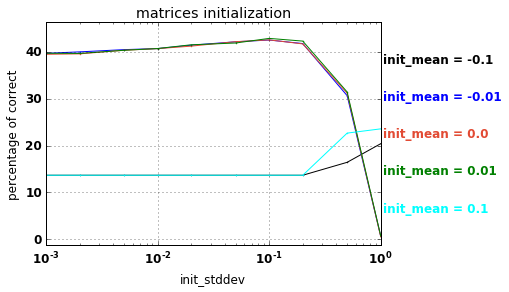

In [12]:
plot_options = {'x': 'log'}
plot_data, _ = rnn_adjustment_plots.one_key_layout_data('rnn_1',
                                                                'init_stddev',
                                         "init_mean")
rnn_adjustment_plots.save_layout(plot_data[0],
                    'matrices initialization',
                    ['adjustment'],
                    'nn128;ns10000;hl500;dc0.9',
                     plot_options=plot_options)
rnn_adjustment_plots.draw(plot_data[0], 'matrices initialization', plot_options=plot_options)

In [8]:
"""learning rate adjustment"""
learning_rate_values = [10., 5., 2., 1., 0.5, 0.2, 0.1, 0.05]
learning_rate_adjustment_results = list()
for i in range(25):
    print('#%s' % i)
    model = RNN(64,
                        vocabulary,
                        characters_positions_in_vocabulary,
                        30,
                        1,
                        [128],
                        train_text,
                        valid_text) 
    model.simple_run(200,
                               'rnn/compare_random_choive/variables',
                               20000,
                               400,
                               5000,        #learning has a chance to be stopped after every block of steps
                               1,
                               1.0,
                               3,
                               fixed_num_steps=True) 
    learning_rate_adjustment_results.extend(model._results)
    model.destroy()
    del model
    gc.collect()

#0
Number of steps = 20000     Percentage = 46.92%     Time = 395s     Learning rate = 0.5000
#1
Number of steps = 20000     Percentage = 45.05%     Time = 396s     Learning rate = 0.5000
#2
Number of steps = 20000     Percentage = 46.77%     Time = 397s     Learning rate = 0.5000
#3
Number of steps = 20000     Percentage = 46.91%     Time = 404s     Learning rate = 0.5000
#4
Number of steps = 20000     Percentage = 46.85%     Time = 403s     Learning rate = 0.5000
#5
Number of steps = 20000     Percentage = 47.00%     Time = 392s     Learning rate = 0.5000
#6
Number of steps = 20000     Percentage = 46.72%     Time = 391s     Learning rate = 0.5000
#7
Number of steps = 20000     Percentage = 46.73%     Time = 393s     Learning rate = 0.5000
#8
Number of steps = 20000     Percentage = 46.44%     Time = 396s     Learning rate = 0.5000
#9
Number of steps = 20000     Percentage = 46.64%     Time = 398s     Learning rate = 0.5000
#10
Number of steps = 20000     Percentage = 46.70%     Time

In [9]:
average = 0
for result in learning_rate_adjustment_results:
    average += result['data']['train']['percentage'][-1]
print(average/25)

46.69353125


In [16]:
"""learning rate adjustment"""
learning_rate_values = [0.02, 0.01, 0.005, 0.002, 0.001]
for learning_rate_value in learning_rate_values:
    print(' '*5, 'learning_rate_value:', learning_rate_value)
    model = RNN(64,
                        vocabulary,
                        characters_positions_in_vocabulary,
                        10,
                        1,
                        [128],
                        train_text,
                        valid_text,
                        init_learning_rate=learning_rate_value) 
    model.simple_run(200,
                               'rnn/variables',
                               10000,
                               400,
                               5000,        #learning has a chance to be stopped after every block of steps
                               1,
                               1.0,
                               3,
                               fixed_num_steps=True) 
    learning_rate_adjustment_results.extend(model._results)
    model.destroy()
    del model
    gc.collect()

      learning_rate_value: 0.02
Number of steps = 10000     Percentage = 27.12%     Time = 77s     Learning rate = 0.0200
      learning_rate_value: 0.01
Number of steps = 10000     Percentage = 23.27%     Time = 77s     Learning rate = 0.0100
      learning_rate_value: 0.005
Number of steps = 10000     Percentage = 15.81%     Time = 77s     Learning rate = 0.0050
      learning_rate_value: 0.002
Number of steps = 10000     Percentage = 13.65%     Time = 77s     Learning rate = 0.0020
      learning_rate_value: 0.001
Number of steps = 10000     Percentage = 13.65%     Time = 76s     Learning rate = 0.0010


In [17]:
folder_name = 'rnn'
file_name = 'rnn_learning_rate_ns_10000_hl_500_dc_0.9_nu_10_mv-0.1_0.1_std0.001-1.pickle'
force = True
pickle_dump = {'adjustment_results': learning_rate_adjustment_results}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling rnn/rnn_learning_rate_ns_10000_hl_500_dc_0.9_nu_10_mv-0.1_0.1_std0.001-1.pickle.


In [8]:
folder_name = 'rnn'
pickle_file = 'rnn_learning_rate_ns_10000_hl_500_dc_0.9_nu_10_mv-0.1_0.1_std0.001-1.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  learning_rate_adjustment_results = save['adjustment_results']
  del save  # hint to help gc free up memory

In [9]:
for result in learning_rate_adjustment_results:
    print(result)

{'metadata': [64, 10, 1, [128], 10000, 1.0, 10000, 200, 0.0, 0.1, 0.0, 10.0, 'rnn'], 'data': {'train': {'step': [-1], 'percentage': [6.18203125]}, 'validation': {'step': [-1], 'percentage': [6.71]}}, 'time': 77.33614600000004}
{'metadata': [64, 10, 1, [128], 10000, 1.0, 10000, 200, 0.0, 0.1, 0.0, 5.0, 'rnn'], 'data': {'train': {'step': [-1], 'percentage': [3.86953125]}, 'validation': {'step': [-1], 'percentage': [4.95]}}, 'time': 82.252749}
{'metadata': [64, 10, 1, [128], 10000, 1.0, 10000, 200, 0.0, 0.1, 0.0, 2.0, 'rnn'], 'data': {'train': {'step': [-1], 'percentage': [37.9046875]}, 'validation': {'step': [-1], 'percentage': [36.31]}}, 'time': 80.958526}
{'metadata': [64, 10, 1, [128], 10000, 1.0, 10000, 200, 0.0, 0.1, 0.0, 1.0, 'rnn'], 'data': {'train': {'step': [-1], 'percentage': [42.9140625]}, 'validation': {'step': [-1], 'percentage': [41.59]}}, 'time': 79.37028199999997}
{'metadata': [64, 10, 1, [128], 10000, 1.0, 10000, 200, 0.0, 0.1, 0.0, 0.5, 'rnn'], 'data': {'train': {'step'

In [10]:
from plot_module import ComparePlots

rnn_learning_rate_plots = ComparePlots('rnn')
rnn_learning_rate_plots.add_network(learning_rate_adjustment_results, model._indices)



[6.18203125]
[3.86953125]
[37.9046875]
[42.9140625]
[41.34140625]
[41.16640625]
[38.0125]
[33.19296875]
[27.12265625]
[23.27421875]
[15.8109375]
[13.65]
[13.65]
There is no labels on plot


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


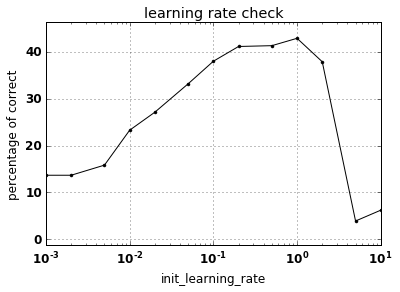

In [11]:
plot_options = {'x': 'log'}
plot_data, _ = rnn_learning_rate_plots.one_key_layout_data('rnn_1',
                                                                'init_learning_rate',
                                         None)
rnn_learning_rate_plots.save_layout(plot_data[0],
                    'learning rate check',
                    ['adjustment'],
                    'nn128;ns10000;hl500;dc0.9',
                     plot_options=plot_options)
rnn_learning_rate_plots.draw(plot_data[0], 'learning rate check', plot_options=plot_options)

In [12]:
print(plot_data[0])

{'layout_variable': None, 'fixed': None, 'data': [{'y': [13.65, 13.65, 15.8109375, 23.27421875, 27.12265625, 33.19296875, 38.0125, 41.16640625, 41.34140625, 42.9140625, 37.9046875, 3.86953125, 6.18203125], 'x': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0], 'layout_value': None}], 'x_variable': ('init_learning_rate', None), 'several_networks': False}


In [32]:
num_layers_values = [-0.1, -0.01, 0., 0.01, 0.1]
num_nodes_values = [96, 128, 192, 256, 384, 512]
num_unrollings_values = [10, 20, 40]

results_GL = list()
for num_nodes_value in num_nodes_values:
    print(' '*5, 'number of nodes:', num_nodes_value)
    for num_unrollings_value in num_unrollings_values:
        print('num_unrollings:', num_unrollings_value)
        model = RNN(64,
                            vocabulary,
                            characters_positions_in_vocabulary,
                            num_unrollings_value,
                            1,
                            [num_nodes_value],
                            train_text,
                            valid_text,
                   init_learning_rate=1.) 
        model.simple_run(200,
                        'rnn/variables',
                         80000,
                         1000,
                                   5000,        #learning has a chance to be stopped after every block of steps
                                   34,
                                   0.9,
                                   3) 
        results_GL.extend(model._results)
        model.destroy()
        del model
        gc.collect()

      number of nodes: 96
num_unrollings: 10
Number of steps = 80001     Percentage = 47.79%     Time = 648s     Learning rate = 0.0278
num_unrollings: 20
Number of steps = 80001     Percentage = 48.62%     Time = 1113s     Learning rate = 0.0278
num_unrollings: 40
Number of steps = 80001     Percentage = 48.73%     Time = 2039s     Learning rate = 0.0278
      number of nodes: 128
num_unrollings: 10
Number of steps = 80001     Percentage = 49.59%     Time = 628s     Learning rate = 0.0278
num_unrollings: 20
Number of steps = 80001     Percentage = 50.40%     Time = 1133s     Learning rate = 0.0278
num_unrollings: 40
Number of steps = 80001     Percentage = 50.77%     Time = 2201s     Learning rate = 0.0278
      number of nodes: 192
num_unrollings: 10
Number of steps = 80001     Percentage = 51.83%     Time = 697s     Learning rate = 0.0278
num_unrollings: 20
Number of steps = 80001     Percentage = 52.95%     Time = 1271s     Learning rate = 0.0278
num_unrollings: 40
Number of steps 

In [33]:
folder_name = 'rnn'
file_name = 'rnn_ns_80000_decay_steps_34_dc_0.9_nl_1_nn96-512_nu_10-40.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling rnn/rnn_ns_80000_decay_steps_34_dc_0.9_nl_1_nn96-512_nu_10-40.pickle.


In [34]:
num_layers_values = [-0.1, -0.01, 0., 0.01, 0.1]
num_nodes_values = [16, 32, 64, 128]
num_unrollings_values = [10, 20, 40]

num_nodes_value = [0, 0]
results_2GL = list()
for num_nodes_value[0] in num_nodes_values:
    print(' '*10, 'number of nodes[0]:', num_nodes_value[0])
    for num_nodes_value[1] in num_nodes_values:
        print(' '*5, 'number of nodes[1]:', num_nodes_value[1])
        for num_unrollings_value in num_unrollings_values:
            print('num_unrollings:', num_unrollings_value)
            model = RNN(64,
                                vocabulary,
                                characters_positions_in_vocabulary,
                                num_unrollings_value,
                                2,
                                [num_nodes_value[0], num_nodes_value[1]],
                                train_text,
                                valid_text,
                       init_learning_rate=1.) 
            model.simple_run(200,
                            'rnn/variables_nl2_ns80000/nn%s_%snu%s' % (num_nodes_value[0], num_nodes_value[1], num_unrollings_value),
                             80000,
                             1000,
                                       5000,        #learning has a chance to be stopped after every block of steps
                                       34,
                                       0.9,
                                       3) 
            results_2GL.extend(model._results)
            model.destroy()
            del model
            gc.collect()

           number of nodes[0]: 16
      number of nodes[1]: 16
num_unrollings: 10
Number of steps = 80001     Percentage = 36.83%     Time = 719s     Learning rate = 0.0278
num_unrollings: 20
Number of steps = 80001     Percentage = 36.90%     Time = 1381s     Learning rate = 0.0278
num_unrollings: 40
Number of steps = 80001     Percentage = 37.67%     Time = 2745s     Learning rate = 0.0278
      number of nodes[1]: 32
num_unrollings: 10
Number of steps = 80001     Percentage = 40.54%     Time = 737s     Learning rate = 0.0278
num_unrollings: 20
Number of steps = 80001     Percentage = 41.08%     Time = 1395s     Learning rate = 0.0278
num_unrollings: 40
Number of steps = 80001     Percentage = 41.23%     Time = 2736s     Learning rate = 0.0278
      number of nodes[1]: 64
num_unrollings: 10
Number of steps = 80001     Percentage = 45.06%     Time = 769s     Learning rate = 0.0278
num_unrollings: 20
Number of steps = 80001     Percentage = 45.70%     Time = 1472s     Learning rate = 0

In [35]:
folder_name = 'rnn'
file_name = 'rnn_ns_80000_hl_2000_dc_0.9_nl_2_nn16-128_nu_10-40.pickle'
force = True
pickle_dump = {'results_GL': results_2GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling rnn/rnn_ns_80000_hl_2000_dc_0.9_nl_2_nn16-128_nu_10-40.pickle.


In [10]:
folder_name = 'rnn'
pickle_file = 'rnn_ns_80000_decay_steps_34_dc_0.9_nl_1_nn96-512_nu_10-40.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [11]:
pickle_file = 'rnn_ns_80000_hl_2000_dc_0.9_nl_2_nn16-128_nu_10-40.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_2GL = save['results_GL']
  del save  # hint to help gc free up memory

In [9]:
folder_name = 'rnn'
pickle_file = 'rnn_ns_80000_hl_2000_dc_0.9_nl_1_nn16-512_nu_10-40.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_old_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [12]:
rnn_plots = ComparePlots('rnn')
rnn_plots.add_network(results_old_GL, model._indices)
rnn_plots.add_network(results_2GL, model._indices)



Network with such structure is already present


In [18]:
rnn_plots.new_metadata('rnn_2', 'num_nodes[0]+num_nodes[1]', 'total_nodes')

1

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


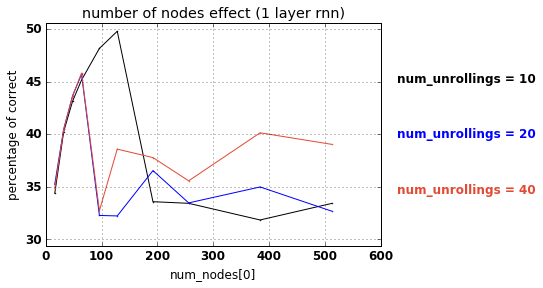

In [15]:
plot_data, _ = rnn_plots.one_key_layout_data('rnn_1',
                                                                'num_nodes[0]',
                                         "num_unrollings")
rnn_plots.save_layout(plot_data[0],
                    'number of nodes effect (1 layer rnn)',
                    ['plots'],
                    'ns80000;decay_steps_40;ilr_2.;dc0.9')
rnn_plots.draw(plot_data[0], 'number of nodes effect (1 layer rnn)')

In [19]:
print(np.sqrt(4))

2.0


In [21]:

base = "a=((((9.%s2.)%s11.)%s13.)%s6.)%s3."
base_print = "9 %s 2 %s 11 %s 13 %s 6 %s 3 = "
operation_sets = [['/', '/', '*', '+', '-'],
                  ['/', '*', '*', '+', '-'],
                  ['/', '*', '+', '+', '-'],
                  ['/', '*', '+', '-', '-']]
for operations1 in operation_sets:
    for idx1, el1 in enumerate(operations1):
        operations2 = list(operations1[:idx1])
        operations2.extend(operations1[idx1+1:])
        for idx2, el2 in enumerate(operations2):
            operations3 = list(operations2[:idx2])
            operations3.extend(operations2[idx2+1:])
            for idx3, el3 in enumerate(operations3):
                operations4 = list(operations3[:idx3])
                operations4.extend(operations3[idx3+1:])
                for idx4, el4 in enumerate(operations4):
                    operations5 = list(operations4[:idx4])
                    operations5.extend(operations4[idx4+1:])
                    for _, el5 in enumerate(operations5):
                        compute = str(base % (el1, el2, el3, el4, el5))
                        exec(compute)
                        if a==45:
                            print(base_print % (el1, el2, el3, el4, el5), a)


9 %s 2 %s 11 %s 13 %s 6 %s 3 = 
9 / 2 + 11 - 13 * 6 * 3 =  45.0
9 / 2 + 11 - 13 * 6 * 3 =  45.0
9 - 2 * 11 + 13 / 6 * 3 =  45.0
9 - 2 * 11 + 13 / 6 * 3 =  45.0


In [19]:
print(9+2*11)

31


In [12]:
iter_num = 3
results_GL = list()   
for i in range(iter_num):
    model = RNN(64,
                             vocabulary,
                             characters_positions_in_vocabulary,
                             30,
                             2,
                             [128, 128],
                             train_text,
                             valid_text)
    model.simple_run(200,
                         'rnn/estimate_variables/average#%s' % i,
                            20000,
                               4000,
                               5000,        #learning has a chance to be stopped after every block of steps
                               30,
                               0.9,
                               3,
                    fixed_num_steps=True)
    results_GL.extend(model._results)
    model.destroy()
    del model

Number of steps = 20000     Percentage = 49.75%     Time = 654s     Learning rate = 0.0212


KeyboardInterrupt: 